In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
from itertools import product

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import numpy as np

from thesis.definitions import STRATEGIES, VERACITIES, SOURCES
from thesis.plotting_utils import get_figsize, set_matplotlib_style, thesis_figure_style

import matplotlib.pyplot as plt

from scipy.stats import bootstrap
from IPython.display import display

In [2]:
DATA_DIR = Path("../data/")
RESULTS_DIR = DATA_DIR / "classification/evaluation_results"
FIGURE_DIR = Path("../figures")
RC_ARGS = {"font.family": "sans-serif", "font.sans-serif": ["Helvetica Neue"]}

SOURCE_MAP = {"openai": "GPT-4", "hf": "WizardLM-13B"}
PROMPT_ORDER = [
    "minimal",
    "crowdworkers",
    "few-shot truthful",
    "few-shot deceptive",
    "persona young",
    "persona old",
    "fake",
]
LLM_ORDER = ["GPT-4", "WizardLM-13B"]
VERACITY_ORDER = ["truthful", "deceptive"]

In [3]:
def get_review_veracity_map() -> dict:
    review_data = pd.read_csv(
        DATA_DIR / "human" / "review_data_preprocessed.csv", index_col="id"
    )

    return review_data["veracity_label"].to_dict()


VERACITY_MAP = get_review_veracity_map()

In [4]:
def exapand_human_to_llm_testsets(data: pd.DataFrame) -> pd.DataFrame:
    human_data = data.loc[data.label == "human"]
    llm_data = data.loc[data.label != "human"]

    test_strategies = pd.Series(llm_data.test_strategy.unique(), name="test_strategy")
    test_sources = pd.Series(llm_data.test_source.unique(), name="test_source")

    human_data = (
        human_data.drop(columns=["test_strategy", "test_source"])
        .merge(test_strategies, how="cross")
        .merge(test_sources, how="cross")
    )

    data = pd.concat([human_data, llm_data], ignore_index=True)

    return data


def sanitize_strategy_name(name):
    if isinstance(name, str):

        name = name.replace("few_shot", "few-shot").replace("_", " ")

    return name


def sanitize_task_data(data: pd.DataFrame, task: tuple) -> pd.DataFrame:
    veracity, source, strategy, split = task

    if not "source" in data.columns:
        data = data.assign(source=pd.NA)
    if not "strategy" in data.columns:
        data = data.assign(strategy=pd.NA)

    data = (
        data.rename(
            columns={
                "source": "test_source",
                "strategy": "test_strategy",
            }
        ).assign(
            # test_veracity=lambda df: df.review_id.map(VERACITY_MAP),
            test_source=lambda df: df.test_source.map(SOURCE_MAP),
            test_strategy=lambda df: df.test_strategy.map(sanitize_strategy_name),
            classifier_split=split,
            classifier_source=SOURCE_MAP[source],
            classifier_strategy=sanitize_strategy_name(strategy),
            classifier_veracity=veracity,
            predictions_0_5=lambda df: df.scores.map(
                lambda x: "llm" if x >= 0.5 else "human"
            ),
        )
        # only keep data with mathcing test and classifier veracity because
        # data for different veracities is not matched
        # .loc[lambda df: (df.test_veracity == df.classifier_veracity)]
    )

    return data


def load_data(file_name: str = "evaluation_results.csv") -> pd.DataFrame:
    tasks = product(VERACITIES, SOURCES, STRATEGIES, [str(i) for i in range(5)])

    task_datasets = list()
    for task in tasks:

        if task[2] == "ape":
            continue

        problem_name = "_".join(task)

        task_data = pd.read_csv(RESULTS_DIR / "bert" / problem_name / file_name).pipe(
            sanitize_task_data, task
        )

        task_datasets.append(task_data)

    data = pd.concat(task_datasets, ignore_index=True)

    return data


def filter_veracity(data: pd.DataFrame) -> pd.DataFrame:
    test_veracity = data.review_id.map(VERACITY_MAP)

    # only keep data with mathcing test and classifier veracity because
    # data for different veracities is not matched
    data = data.loc[lambda df: (test_veracity == df.classifier_veracity)]

    return data


def get_prolific_evalutation_set() -> pd.DataFrame:
    data = load_data().pipe(filter_veracity).pipe(exapand_human_to_llm_testsets)

    return data


def get_amazon_evaluation_set(data: pd.DataFrame) -> pd.DataFrame:
    prolific_data = data.assign(human_source="prolific")

    amazon_data = load_data(file_name="evaluation_results_amazon.csv")

    data = data.loc[lambda df: df.label != "human"]
    amazon_data = (
        pd.concat([data, amazon_data], ignore_index=True)
        .pipe(filter_veracity)
        .pipe(exapand_human_to_llm_testsets)
        .assign(human_source="amazon")
    )

    # TODO remove: unnecessary, concats dataset for evaluating prolific data for evaluation of robustness,
    # but when robustness is evaluated its split again, instead remove this part and the splitting part in later
    # function
    data = pd.concat([prolific_data, amazon_data], ignore_index=True).loc[
        lambda df: df.classifier_veracity == "truthful"
    ]

    return data


def get_salminen_evaluation_set() -> pd.DataFrame:

    data = load_data(file_name="evaluation_results_salminen.csv")

    salminen_reviews = pd.read_csv(
        DATA_DIR / "salminen" / "data_preprocessed.csv", index_col=0
    )
    data = data.join(salminen_reviews.loc[:, "category"], on="review_id")

    return data

In [5]:
def get_metrics(data: pd.DataFrame, pred_name="predictions_0_5") -> pd.Series:
    predictions = data[pred_name]

    return (
        pd.Series(
            {
                "accuracy": accuracy_score(data.label, predictions),
                "precision": precision_score(
                    data.label, predictions, pos_label="llm", zero_division=0
                ),
                "recall": recall_score(
                    data.label, predictions, pos_label="llm", zero_division=0
                ),
                "f1": f1_score(
                    data.label, predictions, pos_label="llm", zero_division=0
                ),
            }
        )
        * 100
    )


def get_confusion_matrix(data: pd.DataFrame, group_by: list[str]):
    cm_list = list()
    for name, group in data.groupby(group_by):
        cm = confusion_matrix(
            group.label, group.predictions, labels=["human", "llm"], normalize="all"
        )

        cm_flat = pd.Series(cm.flatten(), ["tn", "fp", "fn", "tp"], name=name)
        cm_list.append(cm_flat)

    df = pd.DataFrame(cm_list).rename_axis(group_by, axis="index")

    return df


def get_confidence_interval(data):
    bs = bootstrap((data,), np.mean, random_state=42)
    ci = bs.confidence_interval

    return ci.low, ci.high


def get_report(data, control, target="accuracy"):
    accuracies = data.groupby(control)[target]
    ci = accuracies.apply(get_confidence_interval).rename("ci")
    mean_ = accuracies.mean().rename("mean_")

    report = pd.merge(ci, mean_, how="inner", left_index=True, right_index=True).apply(
        lambda df: f"{df.mean_:.2f}\\% [{df.ci[0]:.2f}\\%, {df.ci[1]:.2f}\\%]",
        axis=1,
    )

    return report

## Load data

In [6]:
data = get_prolific_evalutation_set()
amazon_data = get_amazon_evaluation_set(data)
salminen_data = get_salminen_evaluation_set()

In [7]:
metrics = data.groupby(
    [
        "test_source",
        "test_strategy",
        "classifier_veracity",
        "classifier_source",
        "classifier_strategy",
        "classifier_split",
    ]
).apply(get_metrics)

## RQ1

In [8]:
def test_set_filter(df: pd.DataFrame) -> np.ndarray:
    """Only keep results on original test set i.e. only keep rows where the index levels test_strategy and classifier_strategy are equal"""

    idx = df.index

    equal_strategies = idx.get_level_values("test_strategy") == idx.get_level_values(
        "classifier_strategy"
    )
    equal_sources = idx.get_level_values("test_source") == idx.get_level_values(
        "classifier_source"
    )

    return equal_strategies & equal_sources


metrics_rq1 = metrics.loc[test_set_filter].reset_index(
    ["test_source", "test_strategy"], drop=True
)

### RQ1.1 Veracity

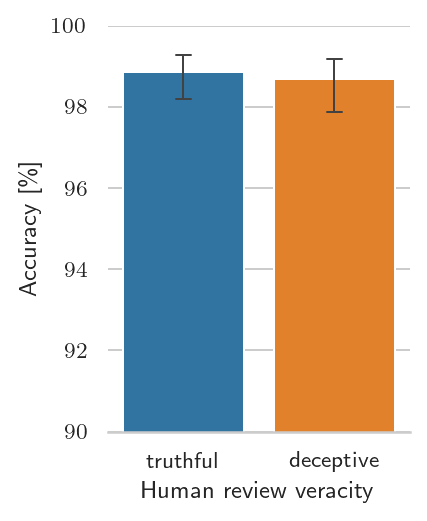

In [9]:
def plot_accuracy_veracity():
    with thesis_figure_style(sns_style_args={"style": "whitegrid"}, rc_args=RC_ARGS):
        fig, ax = plt.subplots(
            1,
            1,
            sharey=True,
            figsize=get_figsize(latex_subfigures=(2, 1), fraction=0.8),
        )
        ax.set_ylim(90, 100)
        ax = sns.barplot(
            data=metrics_rq1,
            x="classifier_veracity",
            y="accuracy",
            hue="classifier_veracity",
            order=VERACITY_ORDER,
            hue_order=VERACITY_ORDER,
            ax=ax,
            capsize=0.1,
            err_kws={"linewidth": 0.8},
            errorbar=get_confidence_interval,
        )
        sns.despine(ax=ax, left=True)
        ax.set_xlabel("Human review veracity")
        ax.set_ylabel(r"Accuracy [\%]")

        fig_path = FIGURE_DIR / "rq_1_1_barplot.pdf"
        fig.savefig(fig_path, format="pdf")

        plt.show()


plot_accuracy_veracity()

In [10]:
get_report(metrics_rq1, "classifier_veracity")

classifier_veracity
deceptive    98.67\% [97.87\%, 99.19\%]
truthful     98.86\% [98.19\%, 99.27\%]
dtype: object

### RQ1.2 LLM

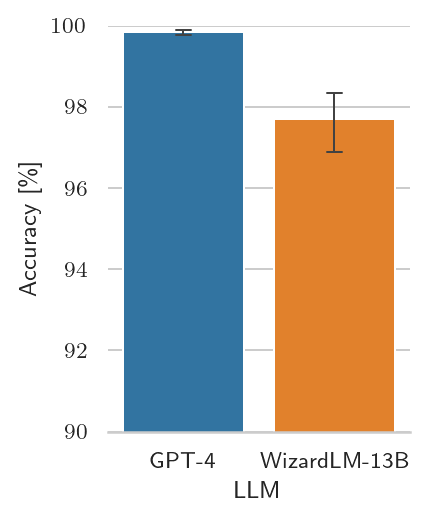

In [11]:
def plot_accuracy_llm():
    with thesis_figure_style(sns_style_args={"style": "whitegrid"}, rc_args=RC_ARGS):
        fig, ax = plt.subplots(
            1,
            1,
            sharey=True,
            figsize=get_figsize(latex_subfigures=(2, 1), fraction=0.8),
        )
        ax.set_ylim(90, 100)
        ax = sns.barplot(
            data=metrics_rq1,
            x="classifier_source",
            y="accuracy",
            hue="classifier_source",
            order=LLM_ORDER,
            hue_order=LLM_ORDER,
            ax=ax,
            capsize=0.1,
            err_kws={"linewidth": 0.8},
            errorbar=get_confidence_interval,
        )
        sns.despine(ax=ax, left=True)
        ax.set_xlabel("LLM")
        ax.set_ylabel(r"Accuracy [\%]")

        fig_path = FIGURE_DIR / "rq_1_2_barplot.pdf"
        fig.savefig(fig_path, format="pdf")

        plt.show()


plot_accuracy_llm()

In [12]:
get_report(metrics_rq1, "classifier_source")

classifier_source
GPT-4           99.83\% [99.76\%, 99.89\%]
WizardLM-13B    97.70\% [96.88\%, 98.34\%]
dtype: object

### RQ1.3 Prompting strategy

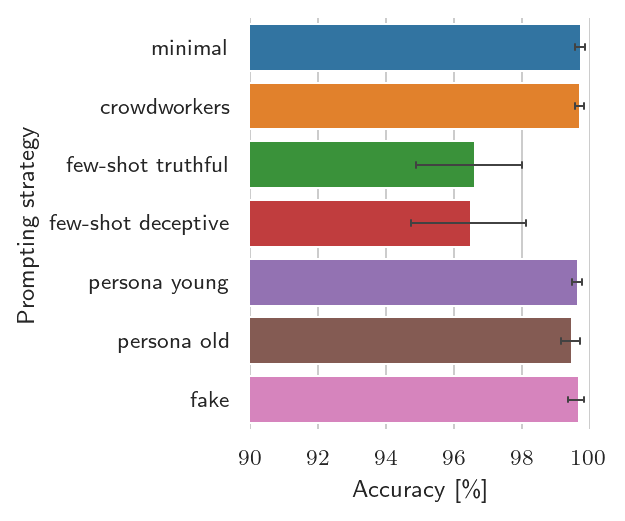

In [13]:
def plot_accuracy_prompting():
    with thesis_figure_style(sns_style_args={"style": "whitegrid"}, rc_args=RC_ARGS):
        fig, ax = plt.subplots(
            1,
            1,
            sharey=True,
            figsize=get_figsize(
                latex_subfigures=(1, 1),
                fraction=0.6,
                aspectratio=((5**0.5 - 1) * 2 / 3),
            ),
        )
        ax.set_xlim(90, 100)
        ax = sns.barplot(
            data=metrics_rq1,
            y="classifier_strategy",
            x="accuracy",
            hue="classifier_strategy",
            order=PROMPT_ORDER,
            hue_order=PROMPT_ORDER,
            ax=ax,
            capsize=0.1,
            err_kws={"linewidth": 0.8},
            errorbar=get_confidence_interval,
        )
        sns.despine(ax=ax, left=True, bottom=True)
        ax.set_ylabel("Prompting strategy")
        ax.set_xlabel(r"Accuracy [\%]")

        fig_path = FIGURE_DIR / "rq_1_3_barplot.pdf"
        fig.savefig(fig_path, format="pdf")

        plt.show()


plot_accuracy_prompting()

In [14]:
get_report(metrics_rq1, "classifier_strategy")

classifier_strategy
crowdworkers          99.70\% [99.55\%, 99.84\%]
fake                  99.67\% [99.36\%, 99.83\%]
few-shot deceptive    96.52\% [94.74\%, 98.13\%]
few-shot truthful     96.62\% [94.89\%, 98.02\%]
minimal               99.74\% [99.57\%, 99.87\%]
persona old           99.46\% [99.16\%, 99.70\%]
persona young         99.65\% [99.48\%, 99.78\%]
dtype: object

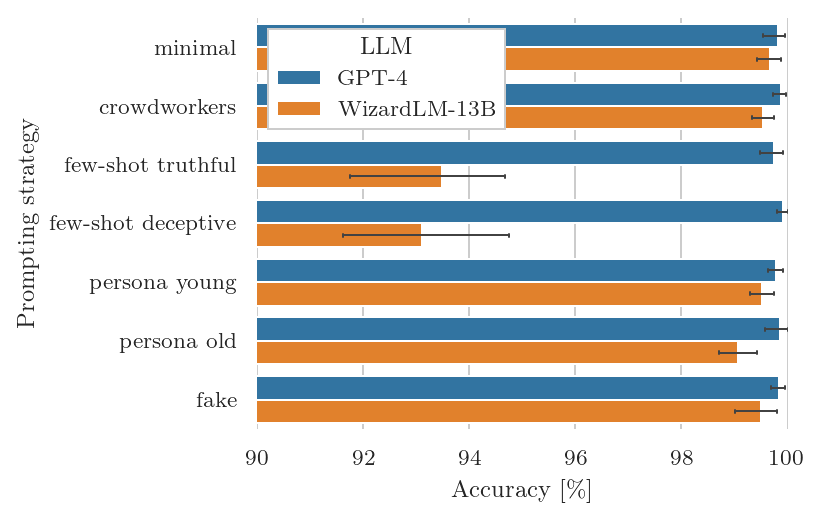

In [15]:
def plot_accuracy_prompting_with_llm():
    with thesis_figure_style(sns_style_args={"style": "whitegrid"}):
        fig, ax = plt.subplots(
            1,
            1,
            sharey=True,
            figsize=get_figsize(latex_subfigures=(1, 1), fraction=0.8),
        )
        ax.set_xlim(90, 100)
        ax = sns.barplot(
            data=metrics_rq1.reset_index().rename(columns={"classifier_source": "LLM"}),
            y="classifier_strategy",
            x="accuracy",
            hue="LLM",
            order=PROMPT_ORDER,
            hue_order=LLM_ORDER,
            ax=ax,
            capsize=0.1,
            err_kws={"linewidth": 0.8},
            errorbar=get_confidence_interval,
        )
        sns.despine(ax=ax, left=True, bottom=True)
        ax.set_ylabel("Prompting strategy")
        ax.set_xlabel(r"Accuracy [\%]")

        fig_path = FIGURE_DIR / "rq_1_3_barplot_with_llm.pgf"
        fig.savefig(fig_path, backend="pgf")

        plt.show()


plot_accuracy_prompting_with_llm()

In [16]:
get_report(metrics_rq1, ["classifier_strategy", "classifier_source"])

classifier_strategy  classifier_source
crowdworkers         GPT-4                 99.87\% [99.72\%, 99.96\%]
                     WizardLM-13B          99.54\% [99.34\%, 99.75\%]
fake                 GPT-4                 99.83\% [99.69\%, 99.95\%]
                     WizardLM-13B          99.51\% [99.01\%, 99.81\%]
few-shot deceptive   GPT-4                99.92\% [99.81\%, 100.00\%]
                     WizardLM-13B          93.11\% [91.62\%, 94.74\%]
few-shot truthful    GPT-4                 99.75\% [99.48\%, 99.92\%]
                     WizardLM-13B          93.49\% [91.75\%, 94.68\%]
minimal              GPT-4                 99.81\% [99.54\%, 99.95\%]
                     WizardLM-13B          99.67\% [99.42\%, 99.88\%]
persona old          GPT-4                99.86\% [99.58\%, 100.00\%]
                     WizardLM-13B          99.07\% [98.71\%, 99.43\%]
persona young        GPT-4                 99.78\% [99.64\%, 99.92\%]
                     WizardLM-13B          99.51\% 

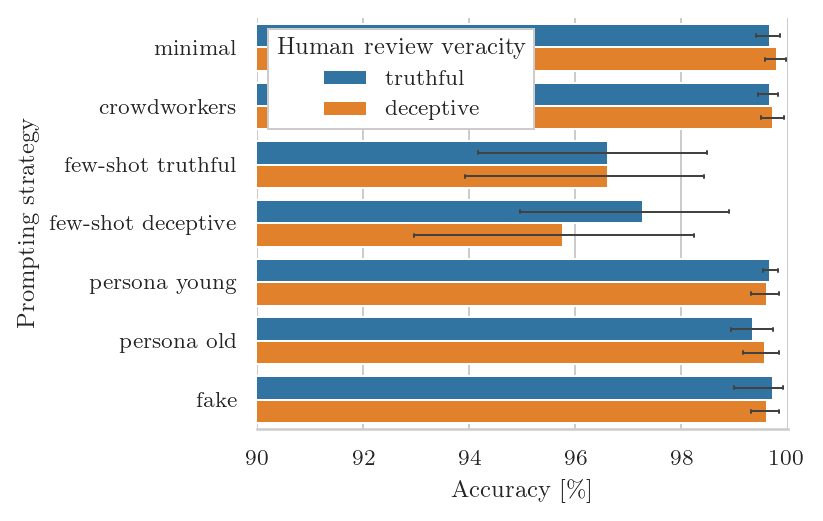

In [17]:
def plot_accuracy_prompting_with_veracity():
    with thesis_figure_style(sns_style_args={"style": "whitegrid"}):
        fig, ax = plt.subplots(
            1,
            1,
            sharey=True,
            figsize=get_figsize(latex_subfigures=(1, 1), fraction=0.8),
        )
        ax.set_xlim(90, 100)
        ax = sns.barplot(
            data=metrics_rq1.reset_index().rename(
                columns={"classifier_veracity": "Human review veracity"}
            ),
            y="classifier_strategy",
            x="accuracy",
            hue="Human review veracity",
            order=PROMPT_ORDER,
            hue_order=VERACITY_ORDER,
            ax=ax,
            capsize=0.1,
            err_kws={"linewidth": 0.8},
            errorbar=get_confidence_interval,
        )
        sns.despine(ax=ax, left=True)
        ax.set_ylabel("Prompting strategy")
        ax.set_xlabel(r"Accuracy [\%]")

        fig_path = FIGURE_DIR / "rq_1_3_barplot_with_veracity.pgf"
        fig.savefig(fig_path, backend="pgf")

        plt.show()


plot_accuracy_prompting_with_veracity()

## RQ2 Robustness

In [18]:
metrics_rq2 = metrics

### RQ2.1 LLM

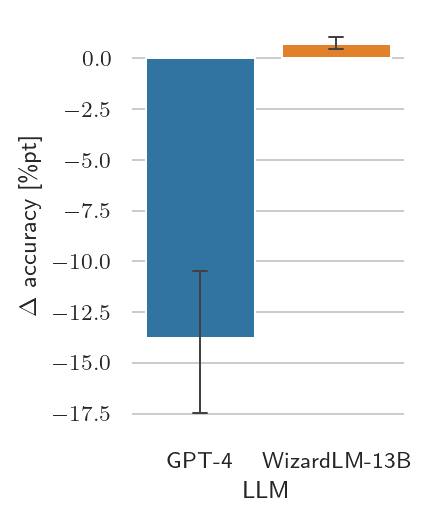

classifier_source
GPT-4           -13.78\% [-17.46\%, -10.49\%]
WizardLM-13B          0.70\% [0.47\%, 1.07\%]
dtype: object

In [19]:
def plot_source_robustness(metrics: pd.DataFrame):
    metrics = metrics.reset_index().loc[
        lambda df: df.test_strategy == df.classifier_strategy
    ]

    same_source_idx = metrics.test_source == metrics.classifier_source
    same_source_accuracy = metrics.loc[same_source_idx]
    different_source_accuracy = metrics.loc[~same_source_idx]

    difference = (
        pd.merge(
            different_source_accuracy,
            same_source_accuracy,
            how="left",
            suffixes=(None, "_same"),
            on=[
                "test_strategy",
                "classifier_veracity",
                "classifier_source",
                "classifier_strategy",
                "classifier_split",
            ],
        ).assign(diff=lambda df: df.accuracy - df.accuracy_same)
        # .reset_index()
    )

    with thesis_figure_style(sns_style_args={"style": "whitegrid"}, rc_args=RC_ARGS):

        fig = plt.figure(figsize=get_figsize(latex_subfigures=(2, 1), fraction=0.8))
        ax = fig.gca()

        sns.barplot(
            data=difference,
            x="classifier_source",
            y="diff",
            hue="classifier_source",
            order=LLM_ORDER,
            hue_order=LLM_ORDER,
            ax=ax,
            capsize=0.1,
            err_kws={"linewidth": 0.8},
            errorbar=get_confidence_interval,
        )
        ax.set_xlabel("LLM")
        ax.set_ylabel(r"$\Delta$ accuracy [\%pt]")
        sns.despine(ax=ax, left=True, bottom=True)

        fig_path = FIGURE_DIR / "rq_2_1_barplot.pdf"
        fig.savefig(fig_path, format="pdf")

        plt.show()

        display(get_report(difference, "classifier_source", "diff"))


plot_source_robustness(metrics_rq2)

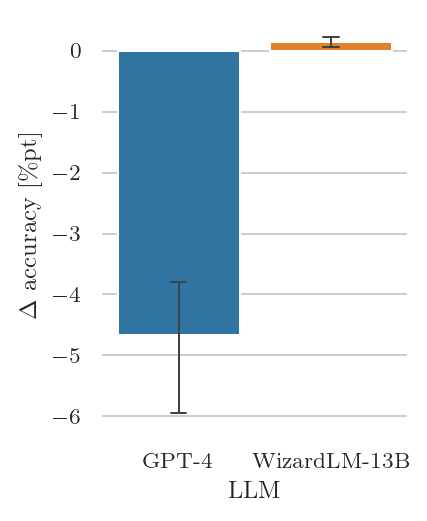

classifier_source
GPT-4           -4.67\% [-5.94\%, -3.79\%]
WizardLM-13B       0.14\% [0.06\%, 0.23\%]
dtype: object

In [20]:
def plot_source_robustness_no_fewshot(metrics: pd.DataFrame):
    metrics = metrics.reset_index().loc[
        lambda df: (df.test_strategy == df.classifier_strategy)
        & ~df.classifier_strategy.str.startswith("few-shot")
    ]

    same_source_idx = metrics.test_source == metrics.classifier_source
    same_source_accuracy = metrics.loc[same_source_idx]
    different_source_accuracy = metrics.loc[~same_source_idx]

    difference = (
        pd.merge(
            different_source_accuracy,
            same_source_accuracy,
            how="left",
            suffixes=(None, "_same"),
            on=[
                "test_strategy",
                "classifier_veracity",
                "classifier_source",
                "classifier_strategy",
                "classifier_split",
            ],
        ).assign(diff=lambda df: df.accuracy - df.accuracy_same)
        # .reset_index()
    )

    with thesis_figure_style(sns_style_args={"style": "whitegrid"}):

        fig = plt.figure(figsize=get_figsize(latex_subfigures=(2, 1), fraction=0.8))
        ax = fig.gca()

        sns.barplot(
            data=difference,
            x="classifier_source",
            y="diff",
            hue="classifier_source",
            order=LLM_ORDER,
            hue_order=LLM_ORDER,
            ax=ax,
            capsize=0.1,
            err_kws={"linewidth": 0.8},
            errorbar=get_confidence_interval,
        )
        ax.set_xlabel("LLM")
        ax.set_ylabel(r"$\Delta$ accuracy [\%pt]")
        sns.despine(ax=ax, left=True, bottom=True)

        fig_path = FIGURE_DIR / "rq_2_1_barplot_no_fewshot.pgf"
        fig.savefig(fig_path, backend="pgf")

        plt.show()

        display(get_report(difference, "classifier_source", "diff"))


plot_source_robustness_no_fewshot(metrics_rq2)

### RQ2.2 Prompting strategy

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica Neue
findfont: Generic family 'sans-serif' not found because none of the following families w

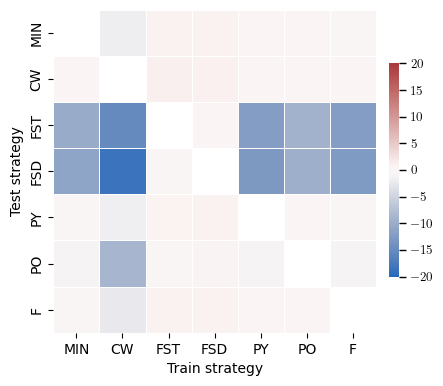

In [21]:
def plot_strategy_robustness_heatmap(metrics: pd.DataFrame):
    prompting_abreviations = {
        "crowdworkers": "CW",
        "minimal": "MIN",
        "fake": "F",
        "few-shot truthful": "FST",
        "few-shot deceptive": "FSD",
        "persona young": "PY",
        "persona old": "PO",
    }

    metrics = metrics.reset_index().loc[
        lambda df: df.test_source == df.classifier_source
    ]

    same_strategy_idx = metrics.test_strategy == metrics.classifier_strategy
    same_strategy_accuracy = metrics.loc[same_strategy_idx]
    different_strategy_accuracy = metrics.loc[~same_strategy_idx]

    difference = pd.merge(
        different_strategy_accuracy,
        same_strategy_accuracy,
        how="left",
        suffixes=(None, "_same"),
        on=[
            "test_source",
            "classifier_veracity",
            "classifier_source",
            "classifier_strategy",
            "classifier_split",
        ],
    ).assign(diff=lambda df: df.accuracy - df.accuracy_same)

    matrix = (
        difference.groupby(["classifier_strategy", "test_strategy"])["diff"]
        .mean()
        .unstack("classifier_strategy")
        .loc[PROMPT_ORDER, PROMPT_ORDER]
        .rename(index=prompting_abreviations, columns=prompting_abreviations)
    )

    fig = plt.figure(figsize=get_figsize(aspectratio=1.0, fraction=0.8))
    ax = fig.gca()

    # "figure.constrained_layout.use": False
    with thesis_figure_style(rc_args=RC_ARGS):
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(
            matrix,
            cmap="vlag",
            center=0,
            vmax=20,
            vmin=-20,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.5},
            ax=ax,
        )

        ax.set_ylabel("Test strategy")
        ax.set_xlabel("Train strategy")

        fig_path = FIGURE_DIR / "rq_2_2_heatmap.pdf"
        fig.savefig(fig_path, format="pdf")

        plt.show()


plot_strategy_robustness_heatmap(metrics_rq2)

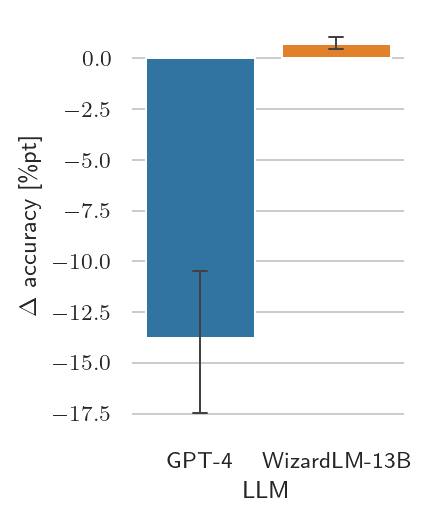

classifier_source
GPT-4           -13.78\% [-17.46\%, -10.49\%]
WizardLM-13B          0.70\% [0.47\%, 1.07\%]
dtype: object

In [22]:
def plot_prompting_robustness(metrics: pd.DataFrame):
    metrics = metrics.reset_index().loc[
        lambda df: df.test_source == df.classifier_source
    ]

    same_strategy_idx = metrics.test_strategy == metrics.classifier_strategy
    same_strategy_accuracy = metrics.loc[same_strategy_idx]
    different_strategy_accuracy = metrics.loc[~same_strategy_idx]

    difference = pd.merge(
        different_strategy_accuracy,
        same_strategy_accuracy,
        how="left",
        suffixes=(None, "_same"),
        on=[
            "test_source",
            "classifier_veracity",
            "classifier_source",
            "classifier_strategy",
            "classifier_split",
        ],
    ).assign(diff=lambda df: df.accuracy - df.accuracy_same)

    with thesis_figure_style(sns_style_args={"style": "whitegrid"}):

        fig = plt.figure(figsize=get_figsize(fraction=0.8))
        ax = fig.gca()

        sns.barplot(
            data=difference,
            y="classifier_strategy",
            x="diff",
            hue="classifier_strategy",
            ax=ax,
            capsize=0.1,
            err_kws={"linewidth": 0.8},
            errorbar=get_confidence_interval,
        )
        ax.set_ylabel("Prompting strategy")
        ax.set_xlabel(r"$\Delta$ accuracy [\%pt]")
        sns.despine(ax=ax, left=True, bottom=True)

        fig_path = FIGURE_DIR / "rq_2_2_barplot.pgf"
        fig.savefig(fig_path, backend="pgf")

        plt.show()

        display(get_report(difference, "classifier_strategy", "diff"))


plot_source_robustness(metrics_rq2)

### RQ3.3 Amazon

In [23]:
amazon_metrics = amazon_data.groupby(
    [
        "test_source",
        "test_strategy",
        "classifier_veracity",
        "classifier_source",
        "classifier_strategy",
        "classifier_split",
        "human_source",
    ]
).apply(get_metrics, "predictions_0_5")

human_source
Amazon    -0.38\% [-0.65\%, -0.17\%]
dtype: object

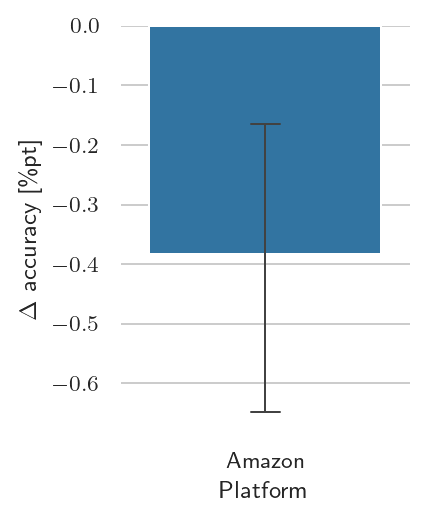

In [24]:
def plot_amazon_robustness(metrics: pd.DataFrame):
    metrics = metrics.reset_index().loc[
        lambda df: (df.test_source == df.classifier_source)
        & (df.test_strategy == df.classifier_strategy)
    ]

    prolific_idx = metrics.human_source == "prolific"
    prolific_accuracy = metrics.loc[prolific_idx]
    amazon_accuracy = metrics.loc[~prolific_idx]

    difference = pd.merge(
        amazon_accuracy,
        prolific_accuracy,
        how="left",
        suffixes=(None, "_same"),
        on=[
            "test_source",
            "test_strategy",
            "classifier_veracity",
            "classifier_source",
            "classifier_strategy",
            "classifier_split",
        ],
    ).assign(
        diff=lambda df: df.accuracy - df.accuracy_same,
        human_source=lambda df: df.human_source.map({"amazon": "Amazon"}),
    )

    with thesis_figure_style(sns_style_args={"style": "whitegrid"}, rc_args=RC_ARGS):

        fig = plt.figure(figsize=get_figsize(latex_subfigures=(2, 1), fraction=0.8))
        ax = fig.gca()

        sns.barplot(
            data=difference,
            x="human_source",
            y="diff",
            ax=ax,
            capsize=0.1,
            err_kws={"linewidth": 0.8},
            errorbar=get_confidence_interval,
        )
        ax.set_ylabel(r"$\Delta$ accuracy [\%pt]")
        ax.set_xlabel("Platform")
        sns.despine(ax=ax, left=True, bottom=True)

        fig_path = FIGURE_DIR / "rq_2_3_barplot.pdf"
        fig.savefig(fig_path, format="pdf")

    display(get_report(difference, control="human_source", target="diff"))

    plt.show()


plot_amazon_robustness(amazon_metrics)

## Salminen

In [25]:
def rq_salminen_cm_report():
    cm_salminen = salminen_data.pipe(
        get_confusion_matrix,
        [
            "classifier_veracity",
            "classifier_source",
            "classifier_strategy",
            "classifier_split",
        ],
    )

    for label, col in cm_salminen.items():
        mean = col.mean()
        ci = get_confidence_interval(col)
        print(f"{label} {mean*100:.2f}\\% [{ci[0]*100:.2f}\\%, {ci[1]*100:.2f}\\%]")


rq_salminen_cm_report()

tn 49.47\% [49.14\%, 49.61\%]
fp 0.53\% [0.39\%, 0.86\%]
fn 49.49\% [49.04\%, 49.71\%]
tp 0.51\% [0.29\%, 0.96\%]


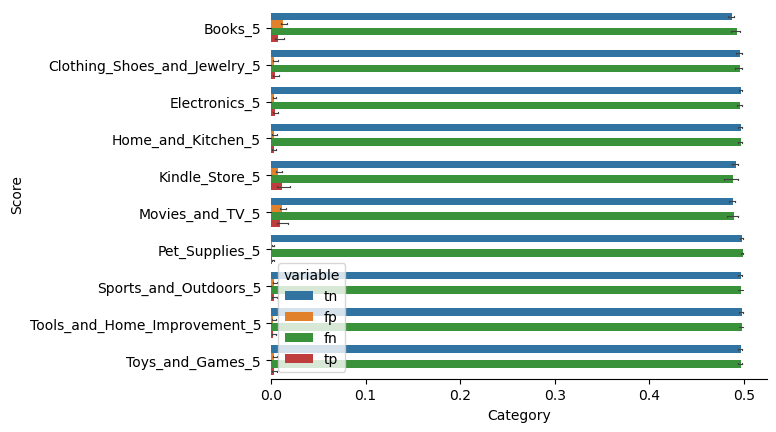

In [26]:
def rq_salminen_plot_cm_categories():
    data = (
        salminen_data.pipe(
            get_confusion_matrix,
            [
                "classifier_veracity",
                "classifier_source",
                "classifier_strategy",
                "classifier_split",
                "category",
            ],
        )
        .reset_index("category")
        .melt("category")
    )

    fig, ax = plt.subplots(
        1,
        1,
        sharey=True,
    )
    ax = sns.barplot(
        data=data,
        x="value",
        y="category",
        hue="variable",
        ax=ax,
        capsize=0.1,
        err_kws={"linewidth": 0.8},
        errorbar=get_confidence_interval,
    )
    sns.despine(ax=ax, left=True)
    ax.set_xlabel("Category")
    ax.set_ylabel(r"Score")

    # fig_path = FIGURE_DIR / "rq_1_1_barplot.pdf"
    # fig.savefig(fig_path, format="pdf")

    plt.show()


rq_salminen_plot_cm_categories()